### SEGFORMER 

**Playground Notebook** <br>
https://huggingface.co/sayeed99/segformer_b3_clothes

**IMPORTS**

In [21]:
# system
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))

from config.path import PathHelper

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
import torch.nn as nn
from torchvision.transforms import ToTensor, ToPILImage


os.path.abspath(os.path.join(os.getcwd(), '../..'))

'/home/kohnle/master-projekt'

**LOAD SAMPLE FILE FROM CLOTH_TYPE**

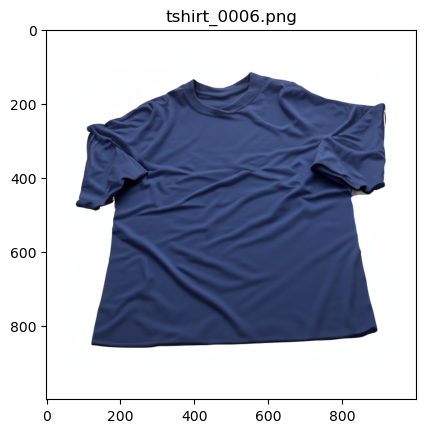

In [22]:
path_helper = PathHelper()

file_name = 'tshirt_0006.png'

img_path = path_helper.get_full_cloth_type_path(file_name)

image = Image.open(img_path).convert('RGB')

plt.imshow(image)
plt.title(file_name)
plt.show()

**LOAD MODEL**

In [11]:
processor = SegformerImageProcessor.from_pretrained("sayeed99/segformer_b3_clothes")
model = AutoModelForSemanticSegmentation.from_pretrained("sayeed99/segformer_b3_clothes")
f'Param: {sum([param.nelement() for param in model.parameters()])}'

'Param: 47236306'

**PROCESSING**

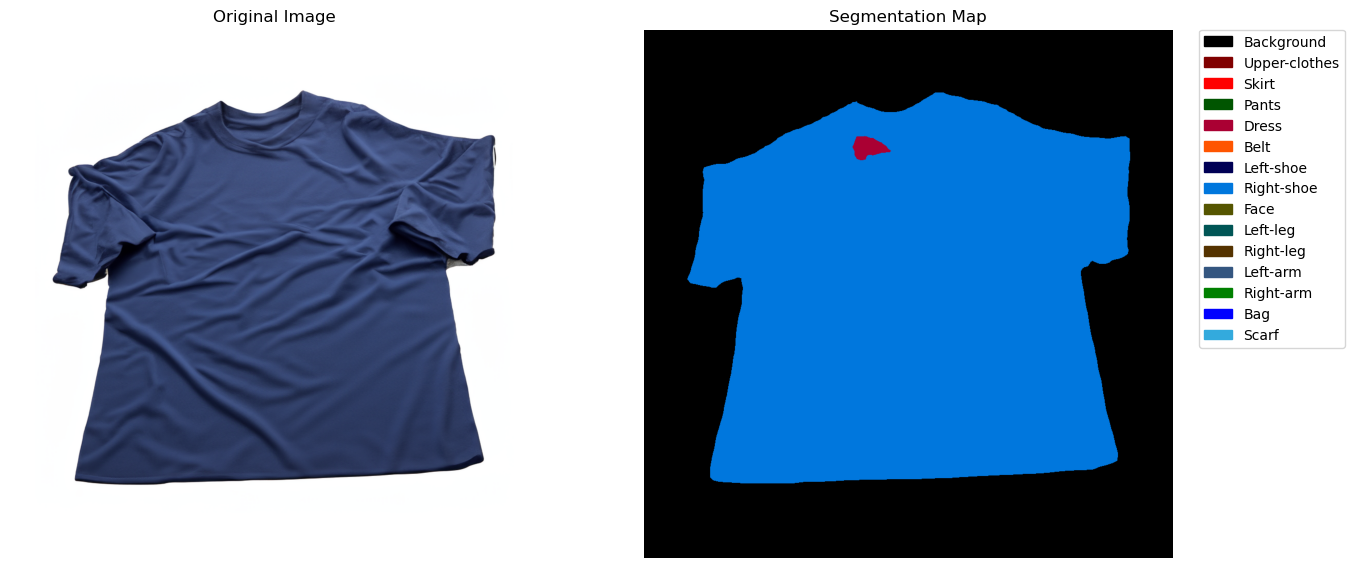

In [19]:
inputs = processor(images=image, return_tensors="pt")

outputs = model(**inputs)
logits = outputs.logits.cpu()

upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0]

# Predefined labels mapping
label_names = [
    "Background", "Upper-clothes", "Skirt",
    "Pants", "Dress", "Belt", "Left-shoe", "Right-shoe", "Face", "Left-leg",
    "Right-leg", "Left-arm", "Right-arm", "Bag", "Scarf"
]

# Define fixed colors for each label in RGB
label_colors = [
    (0, 0, 0),       # Background
    (128, 0, 0),     # Hat
    (255, 0, 0),     # Hair
    (0, 85, 0),      # Sunglasses
    (170, 0, 51),    # Upper-clothes
    (255, 85, 0),    # Skirt
    (0, 0, 85),      # Pants
    (0, 119, 221),   # Dress
    (85, 85, 0),     # Belt
    (0, 85, 85),     # Left-shoe
    (85, 51, 0),     # Right-shoe
    (52, 86, 128),   # Face
    (0, 128, 0),     # Left-leg
    (0, 0, 255),     # Right-leg
    (51, 170, 221),  # Left-arm
    (0, 255, 255),   # Right-arm
    (85, 255, 170),  # Bag
    (170, 255, 85),  # Scarf
]

colors = np.array(label_colors, dtype=np.uint8)
colored_pred = np.zeros((*pred_seg.shape, 3), dtype=np.uint8)
for label_index in range(len(label_names)):
    colored_pred[pred_seg == label_index] = colors[label_index]

# Display the image and the colored segmentation map
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(colored_pred)
plt.axis('off')
plt.title('Segmentation Map')

# Create a legend for the labels
patches = [mpatches.Patch(color=colors[i]/255, label=label_names[i]) for i in range(len(label_names))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

**SEGMENTATION**

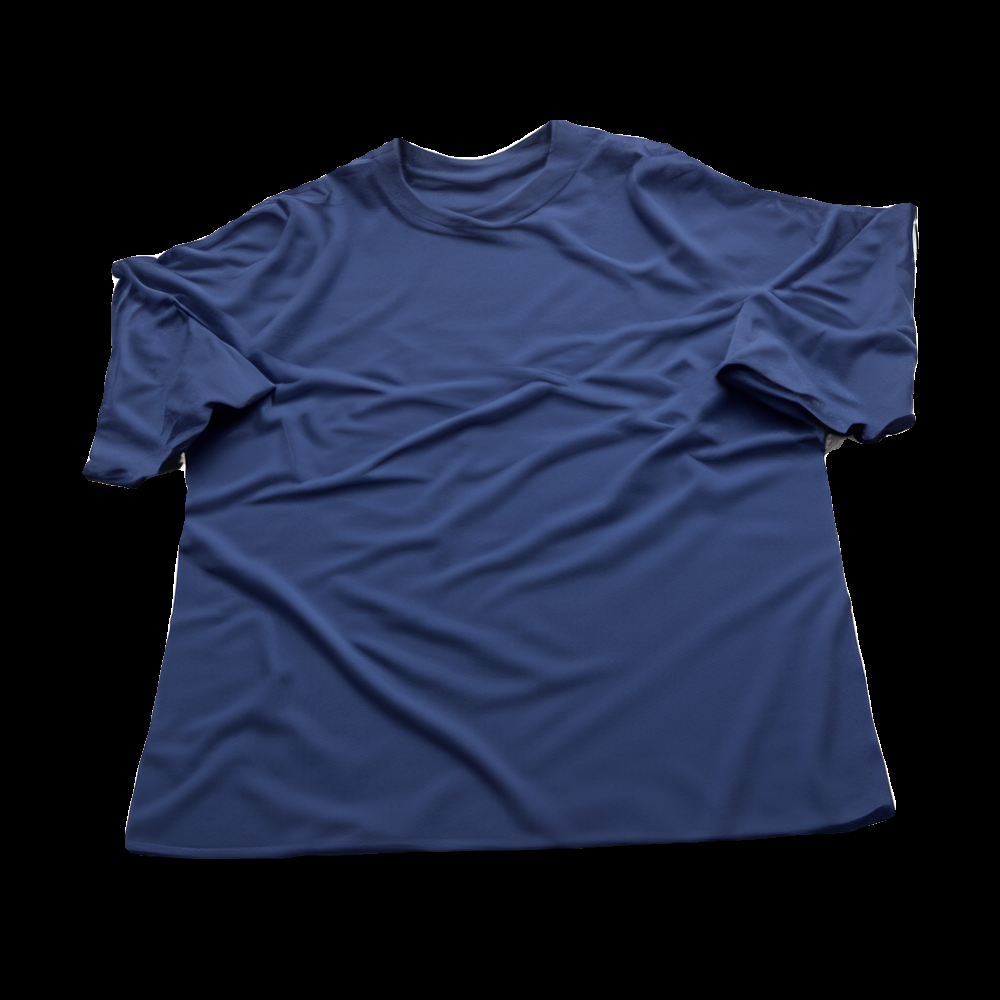

In [20]:
# Step 1: Convert the PIL Image to a PyTorch tensor
transform_to_tensor = ToTensor()
image_tensor = transform_to_tensor(image)

# Ensure the segmentation mask is binary (as before)
segmentation_mask_binary = pred_seg > 0

# Adjust the mask dimensions to match the original image tensor
segmentation_mask_binary_expanded = segmentation_mask_binary.unsqueeze(0).repeat(3, 1, 1)

# Apply the mask to the image tensor
segmented_image_tensor = image_tensor * segmentation_mask_binary_expanded.float()

# Optional: Convert the tensor back to a PIL Image if necessary
transform_to_pil = ToPILImage()
segmented_image = transform_to_pil(segmented_image_tensor)

# Now, 'segmented_image' is a PIL Image containing only the object
segmented_image